In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

from keras.applications.xception import Xception,preprocess_input

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/CSE547/project")

In [4]:
train_images = np.load('train_images.npz')
val_images = np.load('val_images.npz')
test_images = np.load('test_images.npz')

In [5]:
len(train_images.files)

29883

In [6]:
train_images = [train_images[key] for key in train_images.files]
train_images = np.array(train_images)
train_images.shape

(29883, 65536)

In [7]:
train_images=train_images.reshape(29883,256,256)

In [8]:
val_images = [val_images[key] for key in val_images.files]
val_images = np.array(val_images)
val_images=val_images.reshape(6403,256,256)

In [9]:
test_images = [test_images[key] for key in test_images.files]
test_images = np.array(test_images)
test_images=test_images.reshape(6407,256,256)

In [10]:
train_labels = pd.read_csv('train_labels.csv')
val_labels = pd.read_csv('val_labels.csv')
test_labels = pd.read_csv('test_labels.csv')

In [11]:
train_labels

,Unnamed: 0,class,case
0,5780,Astrocytoma,9
1,41892,Astrocytoma,62
2,50748,Astrocytoma,74
3,66607,Astrocytoma,97
4,33034,Astrocytoma,48
...,...,...,...
29878,49517,abnormality,72
29879,28827,abnormality,42
29880,21035,abnormality,30
29881,24907,abnormality,36


In [12]:
train_labels['class'].value_counts()

class
Astrocytoma          9216
Glioblastoma         8658
Oligodendroglioma    6703
abnormality          5306
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
classes=train_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
train_labels= to_categorical(integer_labels)

classes=val_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
val_labels= to_categorical(integer_labels)

classes=test_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
test_labels= to_categorical(integer_labels)

train_images=np.stack((train_images,) * 3, axis=-1)
val_images=np.stack((val_images,) * 3, axis=-1)
test_images=np.stack((test_images,) * 3, axis=-1)

In [14]:
train_images = preprocess_input(train_images)
val_images= preprocess_input(val_images)
test_images=preprocess_input(test_images)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(29883, 4)
(6403, 4)
(6407, 4)
(29883, 256, 256, 3)
(6403, 256, 256, 3)
(6407, 256, 256, 3)


# Resnet Model Training

In [15]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("model_checkpoint1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
import keras

# Transfer Learning using EfficientNetB3
base_model = Xception(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    pooling=None)

inputs = keras.Input(shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
for layer in model.layers[:-10]:
    layer.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [17]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Training
optimizer = Adam(learning_rate=0.0001)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [18]:
import time
start_time = time.time()
history=model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_data=(val_images, val_labels), callbacks=[reduce_lr, checkpoint])
end_time = time.time()

Epoch 1/30
934/934 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.4297
Epoch 1: val_accuracy improved from -inf to 0.48524, saving model to model_checkpoint1.h5
934/934 [==============================] - 54s 48ms/step - loss: 1.2303 - accuracy: 0.4297 - val_loss: 1.1466 - val_accuracy: 0.4852 - lr: 1.0000e-04
Epoch 2/30
933/934 [============================>.] - ETA: 0s - loss: 0.9837 - accuracy: 0.5843
Epoch 2: val_accuracy improved from 0.48524 to 0.52022, saving model to model_checkpoint1.h5
934/934 [==============================] - 36s 39ms/step - loss: 0.9836 - accuracy: 0.5844 - val_loss: 1.0656 - val_accuracy: 0.5202 - lr: 1.0000e-04
Epoch 3/30
934/934 [==============================] - ETA: 0s - loss: 0.7926 - accuracy: 0.6831
Epoch 3: val_accuracy improved from 0.52022 to 0.64329, saving model to model_checkpoint1.h5
934/934 [==============================] - 36s 39ms/step - loss: 0.7926 - accuracy: 0.6831 - val_loss: 0.8689 - val_accuracy: 0.6433 - l

# Train Results

In [19]:
print("Training Time:", end_time - start_time)

Training Time: 1113.1444385051727


In [20]:
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
print("Train Accuracy", training_accuracy[-2])
print("Train Loss", training_loss[-2])

Train Accuracy 0.993474543094635
Train Loss 0.024520669132471085


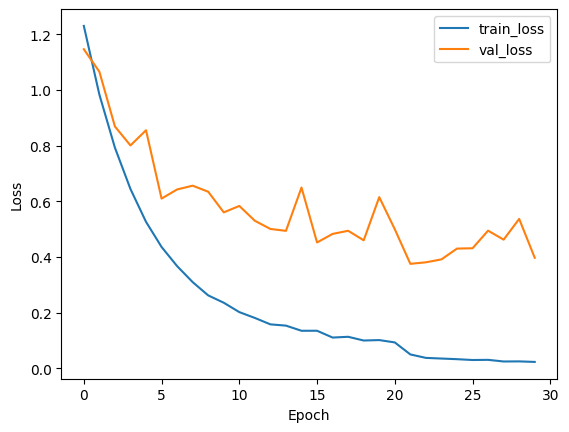

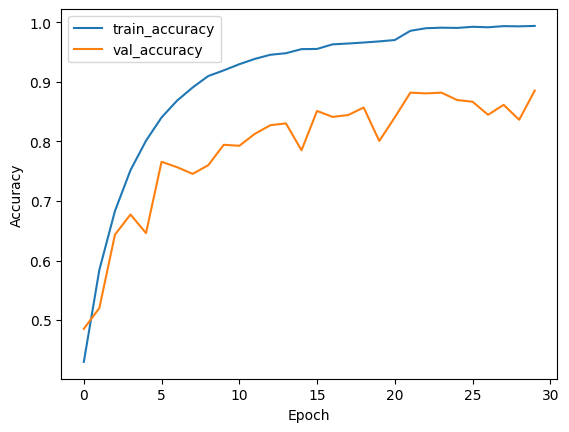

In [21]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

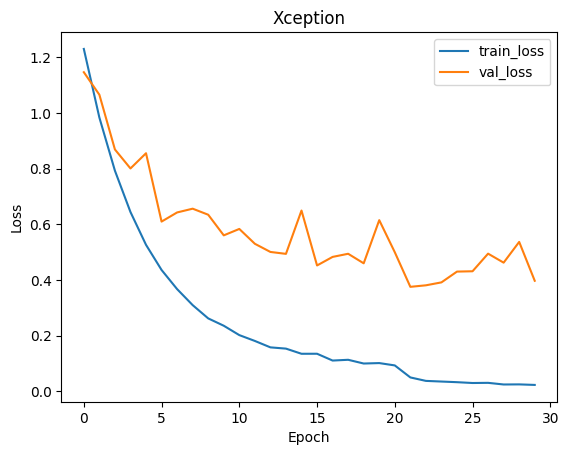

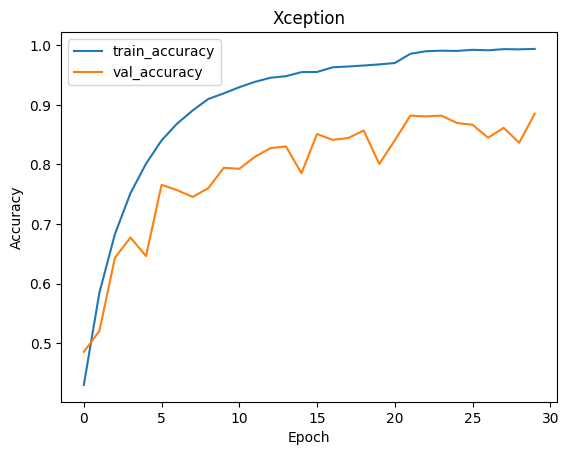

In [22]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Xception')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Xception')
plt.legend()
plt.show()

# Test Results

In [23]:
model.load_weights("model_checkpoint1.h5")

In [24]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print("Validation Accuracy", val_accuracy)
print("Validation Loss", val_loss)

201/201 [==============================] - 8s 42ms/step - loss: 0.3969 - accuracy: 0.8855
Validation Accuracy 0.8855224251747131
Validation Loss 0.39692607522010803


In [25]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Accuracy", test_accuracy)
print("Test Loss", test_loss)

201/201 [==============================] - 9s 43ms/step - loss: 0.4207 - accuracy: 0.8837
Test Accuracy 0.8837209343910217
Test Loss 0.4206823408603668


# Evaluation

In [26]:
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

201/201 [==============================] - 9s 39ms/step


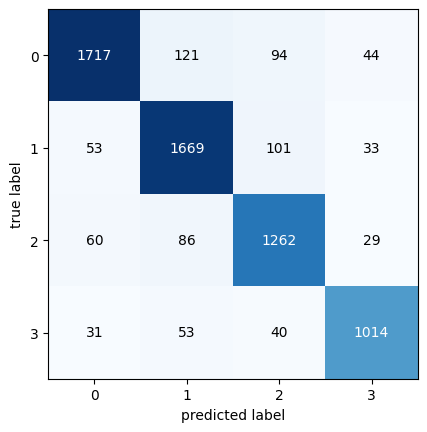

In [27]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plot_confusion_matrix(conf_mat=cm)

In [28]:
from sklearn.metrics import precision_score, recall_score, fbeta_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F2 Score:", f2_score)

Precision: 0.8850719712065328
Recall: 0.8837209302325582
F2 Score: 0.8837148021483697


In [29]:
class_labels = label_encoder.classes_

print("Class Labels:")
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

Class Labels:
Class 0: Astrocytoma
Class 1: Glioblastoma
Class 2: Oligodendroglioma
Class 3: abnormality


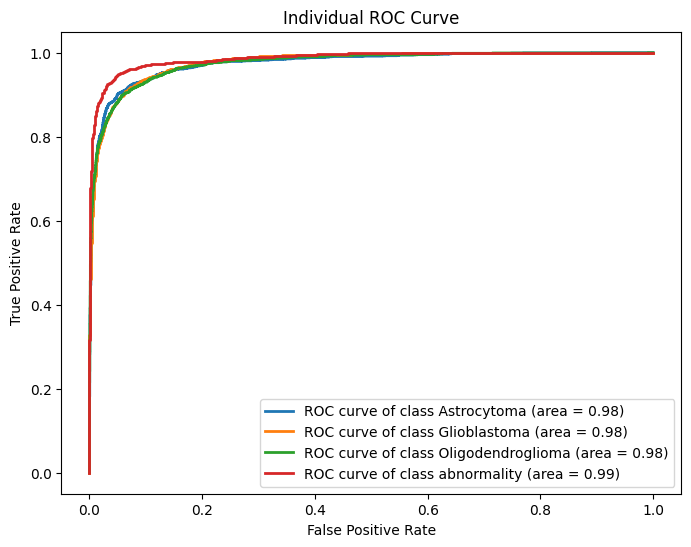

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %s (area = %0.2f)' % (class_labels[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Individual ROC Curve')
plt.legend(loc='lower right')
plt.show()

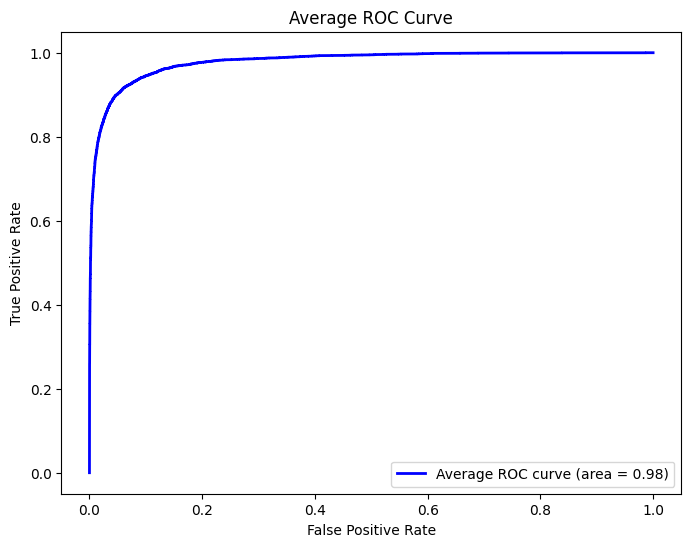

In [31]:
fpr_avg, tpr_avg, _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc_avg = auc(fpr_avg, tpr_avg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc_avg)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc='lower right')
plt.show()